In [1]:
%pwd

'd:\\DeepLearning(project-2)\\Research'

In [2]:
import os 

In [3]:
os.chdir('../')

In [4]:
%pwd

'd:\\DeepLearning(project-2)'

In [ ]:
import os 
import sys
from dataclasses import dataclass
from pathlib import Path
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.losses import  SparseCategoricalCrossentropy
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()),'../')))
from src.constant import CONFIG_FILE_PATH,PARAMS_FILE_PATH
from src.logger import logging
from src.utils.commonFunction import create_directories,read_yaml
from src.exception import CustomException

In [6]:
class_names = ['no','yes']

In [7]:
dataset = tf.keras.utils.image_dataset_from_directory(
"artifacts/data_ingestion/brain_tumor_dataset", 
    labels="inferred",               
    label_mode="int",               
    color_mode="rgb",               
    batch_size=None,                     
    image_size=(256, 256),          
    shuffle=True,                     
    seed=123, 
)

Found 253 files belonging to 2 classes.


In [8]:
def split_dataset(dataset,Train_ratio,Val_ratio,Test_ratio):
    
    data_size = len(dataset)
    
    train_dataset = dataset.take(int(Train_ratio*data_size))
    
    test_val_set = dataset.skip(int(Train_ratio*data_size))
   
    valid_dataset = test_val_set.take(int(Val_ratio*data_size))
    
    test_dataset = test_val_set.skip(int(Val_ratio*data_size))
    
    return train_dataset,valid_dataset,test_dataset

In [9]:
Train_ratio = 0.7
Val_ratio = 0.2
Test_ratio =0.1
train_dataset,valid_dataset,test_dataset = split_dataset(dataset,Train_ratio,Val_ratio,Test_ratio)

In [10]:
print("The length of the train_dataset is : ",len(train_dataset))
print("The length of the valid_dataset : ",len(valid_dataset))
print("The length of the test_dataset : ",len(test_dataset))

The length of the train_dataset is :  177
The length of the valid_dataset :  50
The length of the test_dataset :  26


# load some image

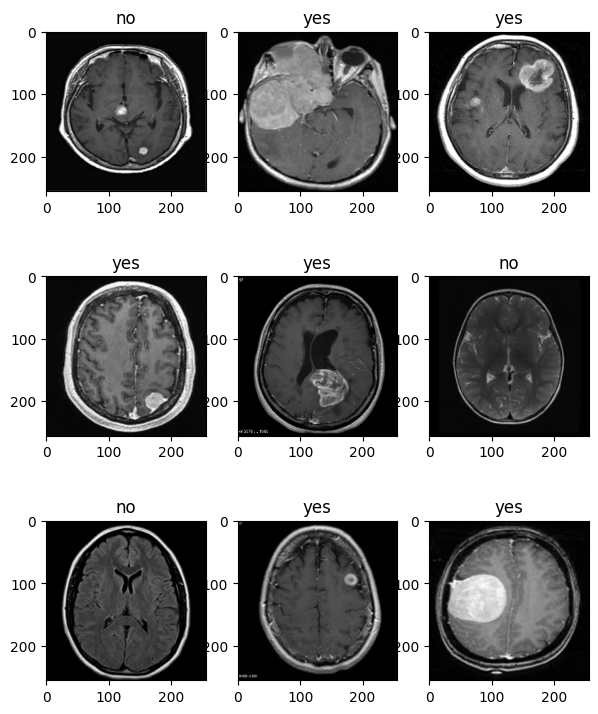

In [11]:
plt.figure(figsize=(7,9))
for i,(image,label) in enumerate(train_dataset.take(9)):
    
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image/255)
    plt.title(class_names[label])

In [12]:
def resize_rescaling(image,label):
    return tf.image.resize(image,(224,224))/255,label

In [13]:
train_dataset = (train_dataset
                .shuffle(buffer_size=8,reshuffle_each_iteration=True)
                .map(resize_rescaling)
                .batch(10)
                .prefetch(tf.data.AUTOTUNE)
                )

In [14]:
valid_dataset = (valid_dataset
                .shuffle(buffer_size=8,reshuffle_each_iteration=True)
                .map(resize_rescaling)
                .batch(5)
                .prefetch(tf.data.AUTOTUNE)
                )

In [15]:
test_dataset = test_dataset.map(resize_rescaling).batch(1)

In [16]:
# train_model 
model = tf.keras.models.load_model('artifacts/base_model/base_model.h5')
model.compile(loss  = SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])
model.summary()

[2025-02-20 16:00:32,861 - 146 No training configuration found in the save file, so the model was *not* compiled. Compile it manually.]


Model: "Lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,442 (896.26 KB)

 Trainable params: 228,994 (894.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
import tensorflow as tf 

In [18]:
# track the mdoel 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=30,
)

In [19]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset
                    ,epochs=50,
                    verbose=1,
                    callbacks =[early_stop]
                    )

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.5960 - loss: 1.5442 - val_accuracy: 0.5800 - val_loss: 1.3622
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6798 - loss: 1.2545 - val_accuracy: 0.6400 - val_loss: 1.3309
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8099 - loss: 1.1502 - val_accuracy: 0.3400 - val_loss: 1.6368
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8877 - loss: 1.0108 - val_accuracy: 0.5600 - val_loss: 1.3560
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7793 - loss: 1.1021 - val_accuracy: 0.4600 - val_loss: 1.3764
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8733 - loss: 0.9905 - val_accuracy: 0.2200 - val_loss: 1.6753
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9011 - loss: 0.9902 - val_accuracy: 0.3000 - val_loss: 1.5972
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8545 - loss: 0.9302 - val_accuracy: 0.6400 - v

In [20]:
model.save('artifacts/training/model.h5')

[2025-02-20 16:01:44,199 - 83 You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. ]
